In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np


c:\Users\razaa\miniconda3\envs\ECE685\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:

class CVAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, num_classes):
        super().__init__()

        self.fc1 = nn.Linear(n_in + num_classes, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)
        self.fc22 = nn.Linear(n_hid, z_dim )
        self.fc3 = nn.Linear(z_dim + num_classes, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, c):
        """Encoder forward pass."""
        x = torch.cat([x, c], 1)
        x = self.fc1(x)
        x = F.relu(x)
        mu = self.fc21(x)
        log_var = self.fc22(x)

        return mu, log_var

        
    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev."""

        var = torch.exp(logvar)
        stddev = torch.sqrt(var)
        z = mu + torch.randn_like(stddev) * stddev
        return z
        
    def decode(self, z, c):
        
        """Decoder forward pass."""

        z = torch.cat([z, c], 1)
        x = self.fc3(z)
        x = F.relu(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)

        return x

        
    def forward(self, x, c):

        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        x_prime = self.decode(z, c)

        return mu, log_var, z, x_prime, c
    
    def neg_elbo_loss(self, mu, log_var, x_prime, x):
        reconstruction_loss = F.binary_cross_entropy(x_prime, x, reduction='sum')
        kl_q_z_given_x_p_x = 0.5 * torch.sum(torch.exp(log_var) + mu.pow(2) - 1 - log_var)

        return reconstruction_loss + kl_q_z_given_x_p_x


In [36]:
from torch.optim import Adam
n_in = 784
n_hid = 400
z_dim = 20
learning_rate = 1e-3
batch_size = 128

In [37]:

MNIST_transform = transforms.Compose([transforms.ToTensor()])

train_val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=MNIST_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=MNIST_transform)

train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size,val_size])


In [38]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [55]:
num_epochs = 50
cvae_model = CVAE(n_in, n_hid, z_dim, 10)
cvae_optimizer = optim.Adam(cvae_model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_loss = 0
    val_loss = 0
    for images, labels in train_loader:
        flattened_images = images.view(images.size(0), -1)
        one_hot_labels = F.one_hot(labels, num_classes=10).float()
        cvae_optimizer.zero_grad()
        mu, log_var, z, x_prime, c = cvae_model(flattened_images, one_hot_labels)
        loss = cvae_model.neg_elbo_loss(mu, log_var, x_prime, flattened_images)
        loss.backward()
        cvae_optimizer.step()

        train_loss += loss

    for images, labels in val_loader:
        flattened_images = images.view(images.size(0), -1)
        one_hot_labels = F.one_hot(labels, num_classes=10).float()
        cvae_optimizer.zero_grad()
        mu, log_var, z, x_prime, c = cvae_model(flattened_images, one_hot_labels)
        loss = cvae_model.neg_elbo_loss(mu, log_var, x_prime, flattened_images)

        val_loss += loss

    print('Epoch {} Training loss: {}'.format(epoch, train_loss/len(train_loader)))
    print('Epoch {} Validation loss: {}'.format(epoch, val_loss/len(val_loader)))
    




Epoch 0 Training loss: 36899.98046875
Epoch 0 Validation loss: 33231.63671875
Epoch 1 Training loss: 32793.8671875
Epoch 1 Validation loss: 32154.9140625
Epoch 2 Training loss: 32018.837890625
Epoch 2 Validation loss: 31590.5234375
Epoch 3 Training loss: 31600.380859375
Epoch 3 Validation loss: 31272.197265625
Epoch 4 Training loss: 31344.095703125
Epoch 4 Validation loss: 31115.279296875
Epoch 5 Training loss: 31168.26953125
Epoch 5 Validation loss: 30909.146484375
Epoch 6 Training loss: 31042.220703125
Epoch 6 Validation loss: 30871.66796875
Epoch 7 Training loss: 30929.23828125
Epoch 7 Validation loss: 30717.423828125
Epoch 8 Training loss: 30849.498046875
Epoch 8 Validation loss: 30638.44140625
Epoch 9 Training loss: 30776.892578125
Epoch 9 Validation loss: 30614.197265625
Epoch 10 Training loss: 30714.947265625
Epoch 10 Validation loss: 30542.294921875
Epoch 11 Training loss: 30664.388671875
Epoch 11 Validation loss: 30483.20703125
Epoch 12 Training loss: 30616.568359375
Epoch 12 

100%|██████████| 79/79 [00:01<00:00, 49.71it/s]


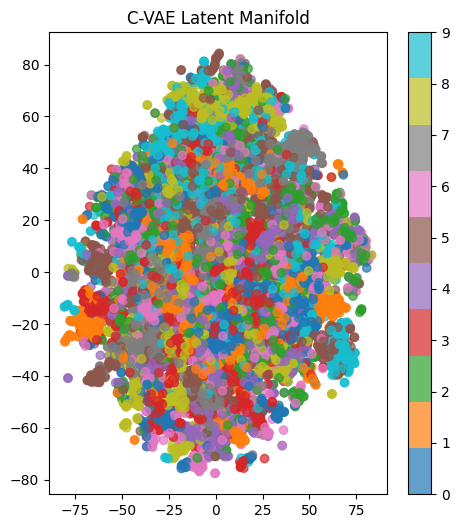

In [ ]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize lists to store VAE and C-VAE latent means and labels
cvae_means, labels = [], []

# Extract latent means from the trained VAE and C-VAE models
with torch.no_grad():
    for data, c in tqdm(test_loader):
        # Reshape data for the models
        data = data.view(-1, 784)
        labels.extend(c)

        # Create one-hot encoding for labels and encode using the C-VAE
        label_onehot = torch.eye(10)[c]
        mu_cvae, _ = cvae_model.encode(data, label_onehot)
        cvae_means.append(mu_cvae.cpu())

# Convert latent means and labels to numpy arrays
cvae_means = torch.cat(cvae_means).numpy()
labels = np.array(labels)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
cvae_2d = tsne.fit_transform(cvae_means)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
cvae_scatter = plt.scatter(cvae_2d[:, 0], cvae_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(cvae_scatter)
plt.title("C-VAE Latent Manifold")

plt.show()


The regular VAE has a discontinuous latent space while the Conditional VAE has a more connected continuous latent space.  The conditional VAE also mixes the different classes more within the latent space than the vanilla VAE.  I hypothesize this is because that the Conditional VAE already takes class into account when encoding a given image, so it doesn't need to separate them out based on class, whereas the Vanilla VAE does since it doesn't have that additional information about class.

In [57]:
cvae_model.eval()


CVAE(
  (fc1): Linear(in_features=794, out_features=400, bias=True)
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=30, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)

In [58]:
batch_size = 16  # Number of images to generate
z_dim = cvae_model.fc21.out_features  # Latent space dimension
num_classes = 10  # Number of classes (assumed based on the dataset)

# Sample latent variables from a standard normal distribution
z = torch.randn(batch_size, z_dim)


In [59]:
# Specify the class indices (e.g., generate for class 0, 1, ..., 9)
class_indices = torch.randint(0, num_classes, (batch_size,))
one_hot_labels = F.one_hot(class_indices, num_classes=num_classes).float()


In [60]:
# Generate images
with torch.no_grad():  # No gradients required during generation
    generated_images = cvae_model.decode(z, one_hot_labels)

# The `generated_images` will be in the range [0, 1] (due to sigmoid activation)
# and might need to be reshaped depending on your dataset.


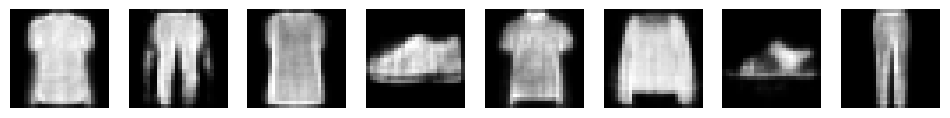

In [61]:
import matplotlib.pyplot as plt

# Assuming the images are flattened; reshape them
image_size = (28, 28)  # Example for MNIST
generated_images = generated_images.view(-1, *image_size)

# Plot a few generated images
fig, axes = plt.subplots(1, 8, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
    ax.axis('off')

plt.show()


In [66]:
num_classes = 10  # Number of classes
examples_per_class = 3
z_dim = cvae_model.fc21.out_features  # Latent space dimension

# Generate 3 samples for each class
z = torch.randn(num_classes * examples_per_class, z_dim)


In [67]:
# Repeat each class index 3 times
class_indices = torch.arange(num_classes).repeat_interleave(examples_per_class)

# One-hot encode class indices
one_hot_labels = F.one_hot(class_indices, num_classes=num_classes).float()


In [68]:
with torch.no_grad():
    generated_images = cvae_model.decode(z, one_hot_labels)


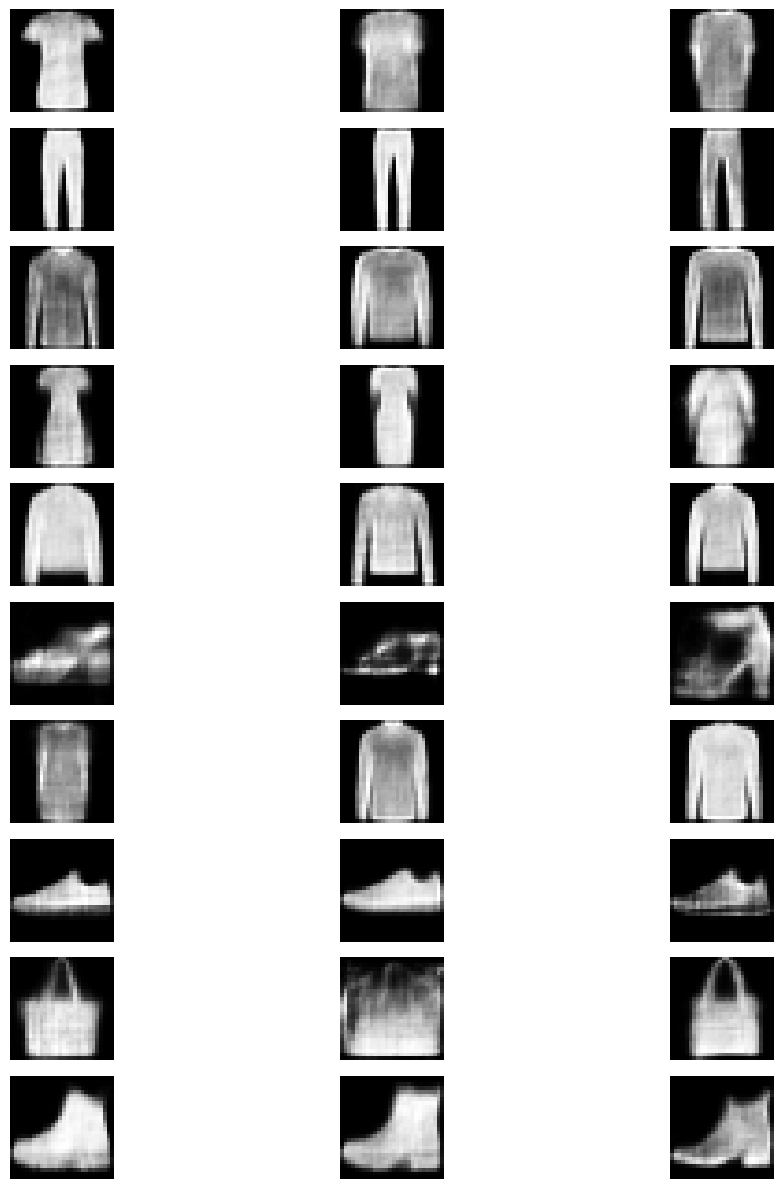

In [ ]:
import matplotlib.pyplot as plt

image_size = (28, 28)
generated_images = generated_images.view(-1, *image_size)

fig, axes = plt.subplots(num_classes, examples_per_class, figsize=(12, 12))
for class_idx in range(num_classes):
    for example_idx in range(examples_per_class):
        ax = axes[class_idx, example_idx]
        img_idx = class_idx * examples_per_class + example_idx
        ax.imshow(generated_images[img_idx].cpu().numpy(), cmap='gray')
        ax.axis('off')
    axes[class_idx, 0].set_ylabel(f"Class {class_idx}", fontsize=10)

plt.tight_layout()
plt.show()
